## Computing EERs Using Simple Threshold Analysis

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as sig
import pandas as pd
import glob
import warnings

from numpy.fft import fft

warnings.filterwarnings('ignore')

In [37]:
TRUSTCOM_DATA_FILES=glob.glob("trustcom_data/*.csv")
MOST_DATA_FILES=glob.glob("most_data/*.csv")
THRESHOLDS=100000
print("Trustcom:",TRUSTCOM_DATA_FILES)
print("MoST:",MOST_DATA_FILES)
trustcom_sensor_frames = [pd.read_csv(file) for file in TRUSTCOM_DATA_FILES]
most_sensor_frames = [pd.read_csv(file) for file in MOST_DATA_FILES]

Trustcom: ['trustcom_data/Accelerometer.csv', 'trustcom_data/Light.csv', 'trustcom_data/Gyroscope.csv', 'trustcom_data/MagneticField.csv', 'trustcom_data/LinearAcceleration.csv', 'trustcom_data/RotationVector.csv', 'trustcom_data/Gravity.csv']
MoST: ['most_data/GeomagneticRotationVector.csv', 'most_data/Sound.csv', 'most_data/Proximity.csv', 'most_data/Pressure.csv', 'most_data/Accelerometer.csv', 'most_data/Light.csv', 'most_data/Gyroscope.csv', 'most_data/MagneticField.csv', 'most_data/LinearAcceleration.csv', 'most_data/RotationVector.csv', 'most_data/Gravity.csv']


In [38]:
def mae(a, b):
    """ Mean absolute error """
    return np.mean(np.abs(a - b))

def corr(a, b):
    """ Pearson's Correlation Coefficient """
    return np.corrcoef(a, b)[0,1]

def cross_corr(a, b):
    """ Max cross correlation """
    return np.max(sig.correlate(a, b))

def coherence(a, b):
    """ Sum of spectral coherences """
    _, Cxy = sig.coherence(a,b,nperseg=len(a)//2)
    return sum(Cxy)

def tf_diff(a, b):
    """ Time frequency difference """
    return np.sqrt(((1.-cross_corr(a,b))**2) + (euclid(fft(a), fft(b))**2))

def euclid(a, b):
    """ Euclidean distance """
    return np.linalg.norm(b-a)

def apply_metric(shared_group, f, d, key):
    """ Iterates each group of shared_group, applies
    similarity metric, f, and inserts into d[key] """
    for shared_id,group in shared_group:
        a,b = group.iloc[:,1:-1].as_matrix()
        try:
            c = f(a,b)
        except Exception:
            c = np.nan
        if not np.isnan(c):
            d[key].append(c)
    
def get_similarities(sensor_frame, f, i): 
    """ Compute similarity metrics for a given frame """
    # Group by legal and illegal transaction groups
    groups = sensor_frame.groupby("genuine_transaction")
    legal_group = groups.get_group(1)
    illegal_group = groups.get_group(0)
    # Group by shared IDs for legal and illegal transactions
    legals = legal_group.groupby("shared_id")
    illegals = illegal_group.groupby("shared_id")
    
    # Apply metrics on +/- data
    data = {'legal':[], 'illegal':[]}
    apply_metric(legals, f, data, 'legal')
    apply_metric(illegals, f, data, 'illegal')
    return data

def find_eer_index(fprs, fnrs):
    """ Returns index of FPR and FNR crossover """
    for i, _ in enumerate(fnrs):
        if fnrs[i] <= fprs[i]:
            return i
    return None

def compute_eer(poss, negs):
    """ Compute EER for given + and - labelled similarities """
    fprs, fnrs = [], []
    ts = np.linspace(min(min(negs), min(poss)), 
                     max(max(negs), max(poss)),
                     num=THRESHOLDS)
    for t in ts:
        fps, fns, tps, tns = 0, 0, 0, 0
        for n in negs:
            if n <= t:
                fps += 1                
            else:
                tns += 1
        for p in poss:
            if p <= t:
                tps += 1
            else:
                fns += 1
                
        # Store fpr,fnr for plotting graphs
        fpr = fps / (fps + tns); fprs.append(fpr);
        fnr = fns / (fns + tps); fnrs.append(fnr);
    eer_i = find_eer_index(fprs, fnrs)
    return(fprs, fnrs, fnrs[eer_i], ts[eer_i], ts)

def analyse(data, method=None, i=None):
    fprs, fnrs, eer, t, ts = compute_eer(data['legal'], data['illegal'])
    print("EER:", eer, "t:",t)
    fig, ax = plt.subplots()
    ax.plot(ts, fprs, 'b--', label='FAR')
    ax.plot(ts, fnrs, 'r', label='FRR')
    ax.grid(linestyle='-')
    ax.legend(loc=1)
    if method and i==4:
        plt.xlabel("Threshold")
        plt.ylabel("Rate")
        plt.savefig("method.pdf", format="pdf")
    plt.show()

################# MOST ANALYSIS ######################
Analysing most_data/GeomagneticRotationVector.csv
*** MAE ***
EER: 0.44906033630069236 t: 0.072443570785


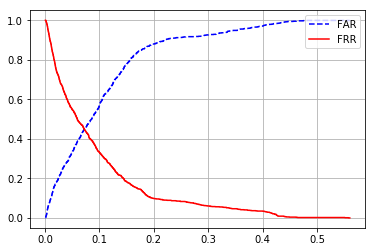

*** CORRELATION ***
EER: 0.5143422354104846 t: 0.0395038301652


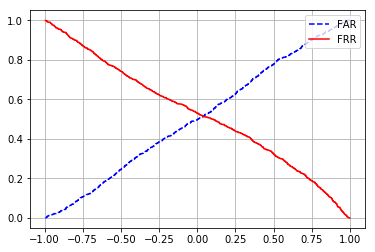

*** CROSS_CORRELATION ***
EER: 0.5004945598417408 t: 87.0943087336


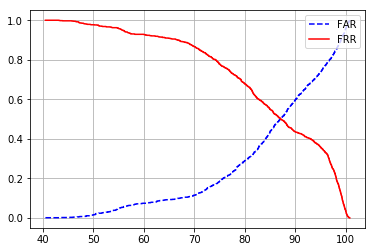

*** EUCLIDEAN DISTANCE ***
EER: 0.4421364985163205 t: 0.822575173085


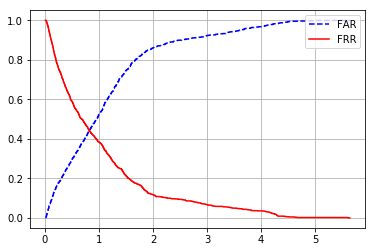

*** COHERENCE ***
EER: 0.5242334322453017 t: 10.6298187074


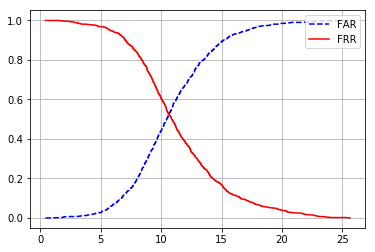

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.49851632047477745 t: 86.9991246505


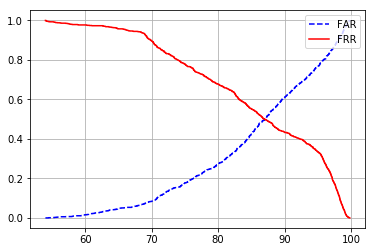

Analysing most_data/Sound.csv
*** MAE ***
EER: 0.3432406519654842 t: 6.1218388585


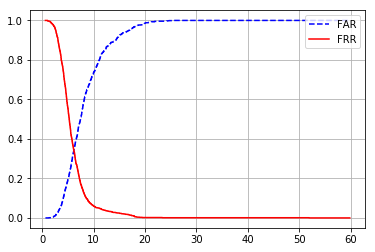

*** CORRELATION ***
EER: 0.5551294343240653 t: 0.920980226585


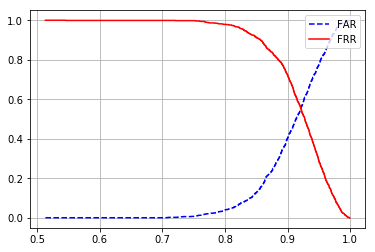

*** CROSS_CORRELATION ***
EER: 0.4813039309683605 t: 64744.9116468


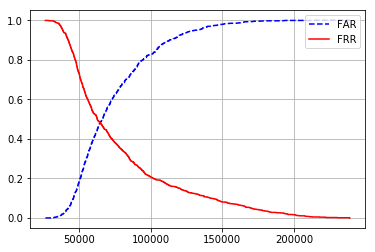

*** EUCLIDEAN DISTANCE ***
EER: 0.33844678811121764 t: 97.2614316451


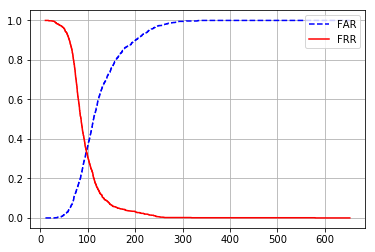

*** COHERENCE ***
EER: 0.5177372962607862 t: 23.8118634712


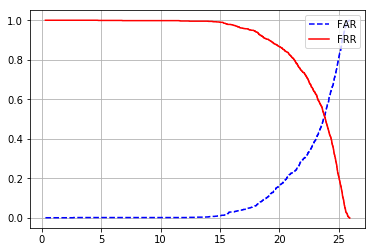

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.4813039309683605 t: 64748.0350263


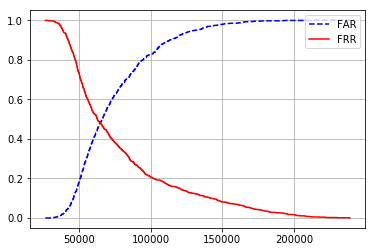

Skipping proximity...
Analysing most_data/Pressure.csv
*** MAE ***
EER: 0.2837301587301587 t: 2.78285757176


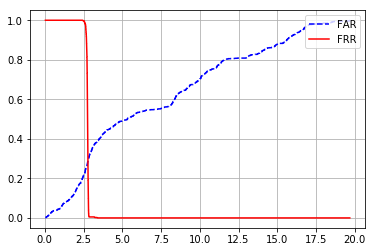

*** CORRELATION ***
EER: 0.6339285714285714 t: 0.305224206657


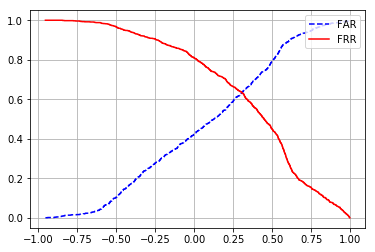

*** CROSS_CORRELATION ***
EER: 0.6011904761904762 t: 104174552.391


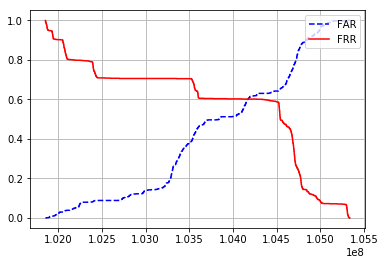

*** EUCLIDEAN DISTANCE ***
EER: 0.2837301587301587 t: 27.9684827244


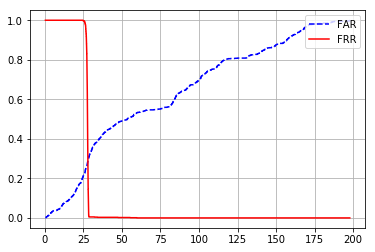

*** COHERENCE ***
EER: 0.5034825870646766 t: 17.2837746755


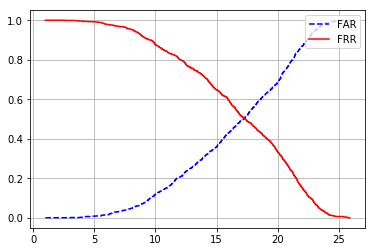

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.6011904761904762 t: 104174551.391


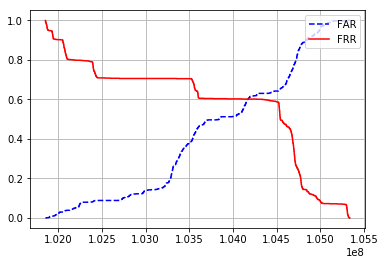

Analysing most_data/Accelerometer.csv
*** MAE ***
EER: 0.4950592885375494 t: 0.649239021543


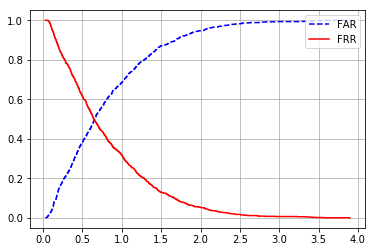

*** CORRELATION ***
EER: 0.49308300395256915 t: -2.26475410859e-05


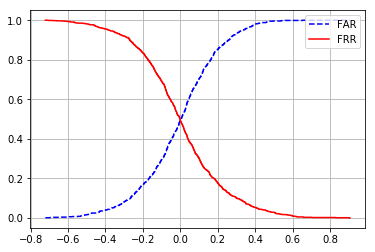

*** CROSS_CORRELATION ***
EER: 0.5019762845849802 t: 9656.79719789


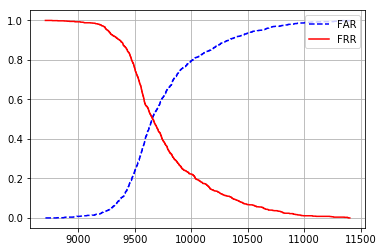

*** EUCLIDEAN DISTANCE ***
EER: 0.4980237154150198 t: 8.66842684724


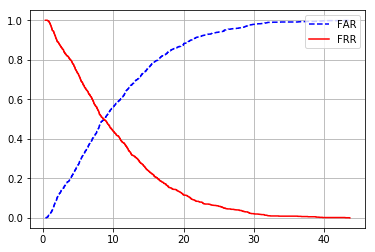

*** COHERENCE ***
EER: 0.5424901185770751 t: 9.42223548442


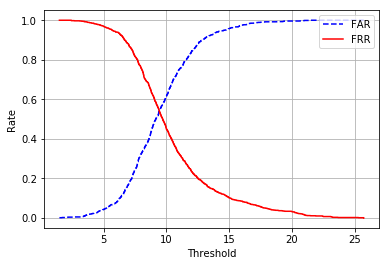

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.5019762845849802 t: 9656.42698564


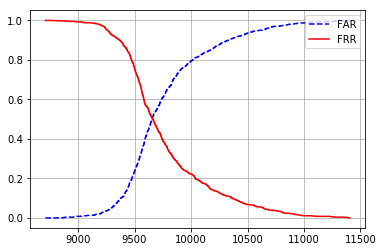

Analysing most_data/Light.csv
*** MAE ***
EER: 0.5014691478942214 t: 171.359521912


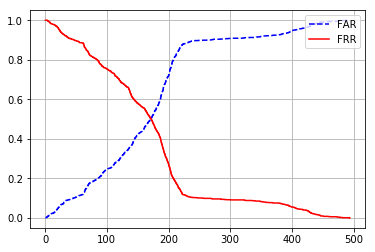

*** CORRELATION ***
EER: 0.5 t: 0.0299304608176


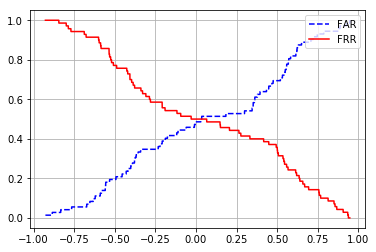

*** CROSS_CORRELATION ***
EER: 0.545543584720862 t: 95529.5719657


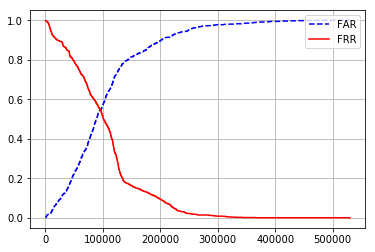

*** EUCLIDEAN DISTANCE ***
EER: 0.5024485798237023 t: 1729.79294775


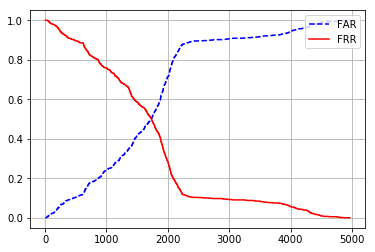

*** COHERENCE ***
EER: 0.4714285714285714 t: 8.82134094166


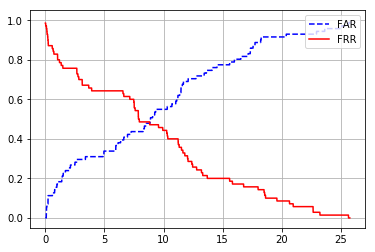

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.5465230166503428 t: 97040.2979596


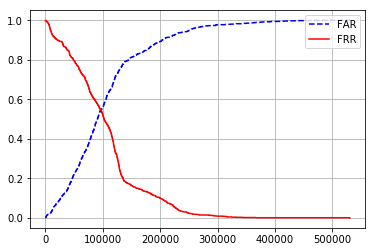

Analysing most_data/Gyroscope.csv
*** MAE ***
EER: 0.49851632047477745 t: 0.517646075758


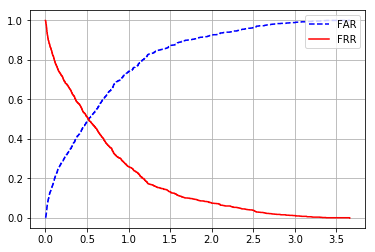

*** CORRELATION ***
EER: 0.45438898450946646 t: -0.0837007712371


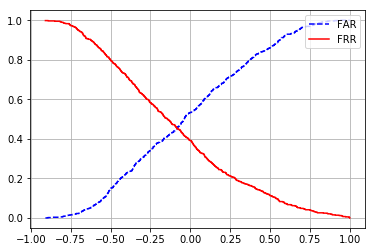

*** CROSS_CORRELATION ***
EER: 0.49258160237388726 t: 0.0163149236427


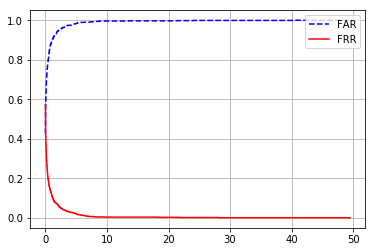

*** EUCLIDEAN DISTANCE ***
EER: 0.49851632047477745 t: 5.89229869957


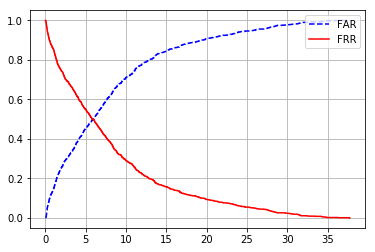

*** COHERENCE ***
EER: 0.5482758620689655 t: 12.745091567


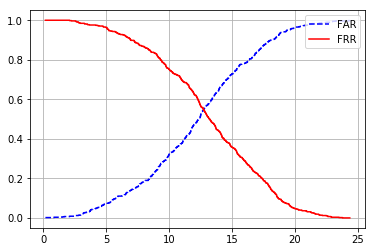

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.49851632047477745 t: 59.2663189539


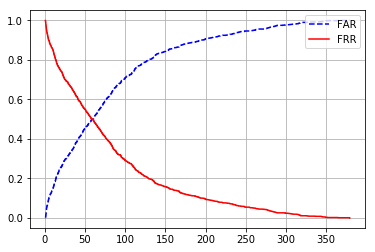

Analysing most_data/MagneticField.csv
*** MAE ***
EER: 0.3326732673267327 t: 73.8821977473


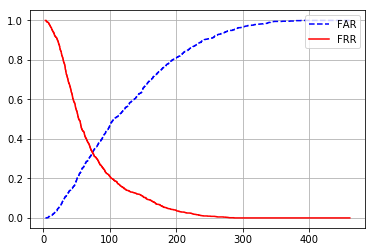

*** CORRELATION ***
EER: 0.5742574257425742 t: 0.254362514427


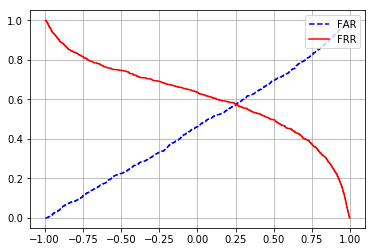

*** CROSS_CORRELATION ***
EER: 0.5366336633663367 t: 2302769.64677


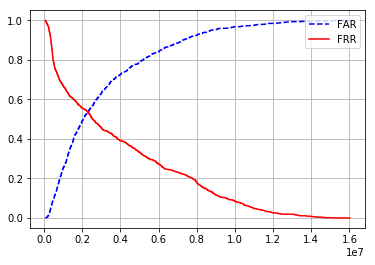

*** EUCLIDEAN DISTANCE ***
EER: 0.33663366336633666 t: 842.72689464


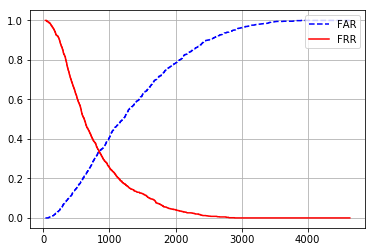

*** COHERENCE ***
EER: 0.5683168316831683 t: 11.9917996106


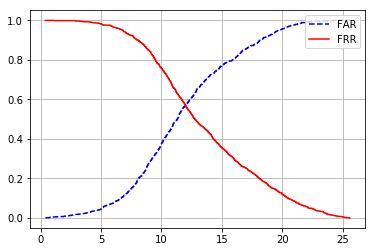

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.5366336633663367 t: 2302858.6802


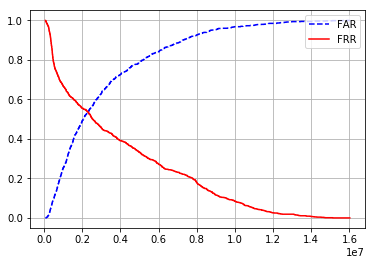

Analysing most_data/LinearAcceleration.csv
*** MAE ***
EER: 0.5039370078740157 t: 1.32228959737


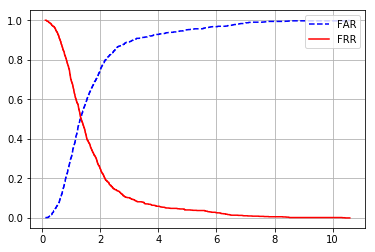

*** CORRELATION ***
EER: 0.4812992125984252 t: 0.060916469334


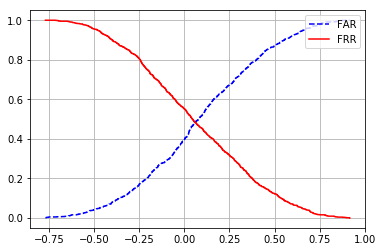

*** CROSS_CORRELATION ***
EER: 0.4940944881889764 t: 36.653685515


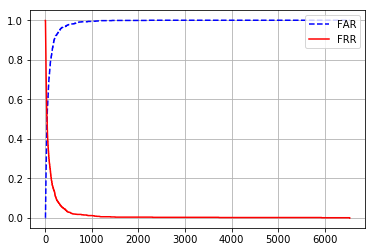

*** EUCLIDEAN DISTANCE ***
EER: 0.5078740157480315 t: 15.7365786917


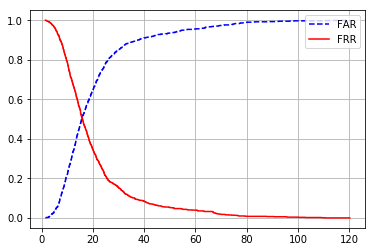

*** COHERENCE ***
EER: 0.5078740157480315 t: 11.5648904548


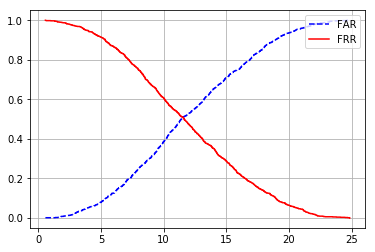

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.5 t: 178.499648217


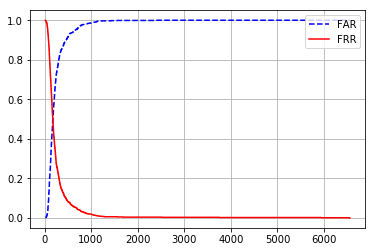

Analysing most_data/RotationVector.csv
*** MAE ***
EER: 0.2755203171456888 t: 0.0


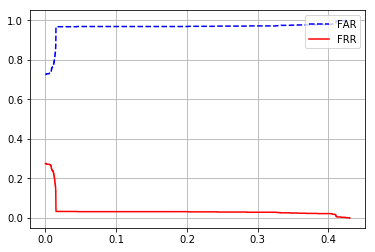

*** CORRELATION ***
EER: 0.0 t: 1.0


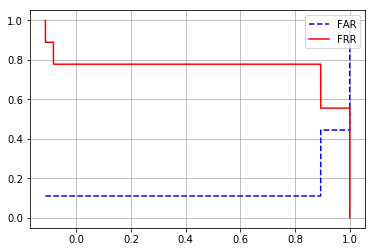

*** CROSS_CORRELATION ***
EER: 0.008919722497522299 t: 0.0


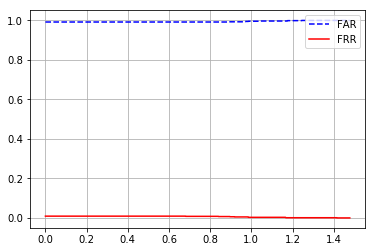

*** EUCLIDEAN DISTANCE ***
EER: 0.2755203171456888 t: 0.0


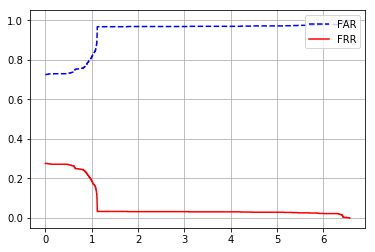

*** COHERENCE ***
EER: 0.0 t: 26.0


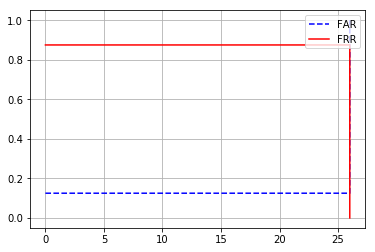

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.27353815659068387 t: 1.00046795974


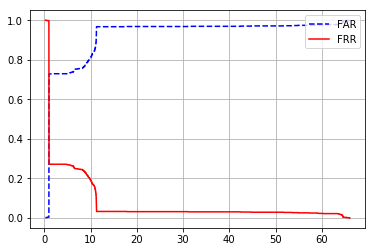

Analysing most_data/Gravity.csv
*** MAE ***
EER: 0.5 t: 9.46436679331e-05


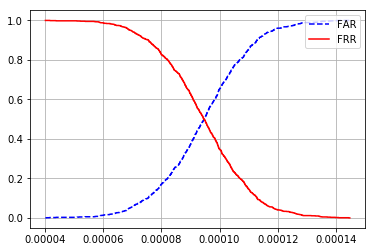

*** CORRELATION ***
EER: 0.49608610567514677 t: 0.00815741149512


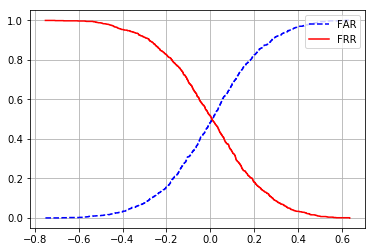

*** CROSS_CORRELATION ***
EER: 0.4980430528375734 t: 9713.1154465


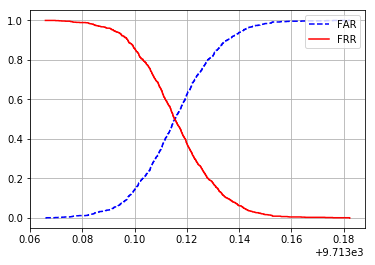

*** EUCLIDEAN DISTANCE ***
EER: 0.5019569471624267 t: 0.00103657718592


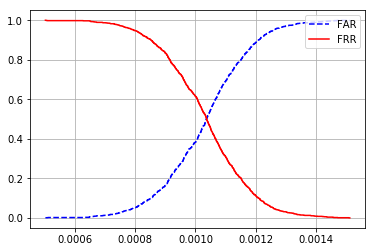

*** COHERENCE ***
EER: 0.5068493150684932 t: 8.44914835667


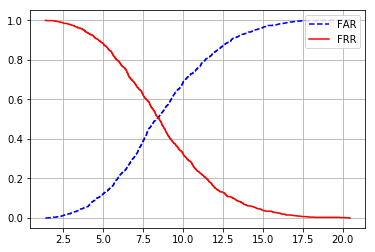

*** TIME FREQUENCY DIFFERENCE ***
EER: 0.4980430528375734 t: 9712.11544651


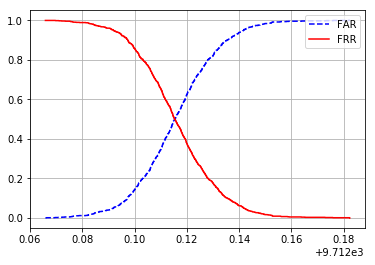

In [39]:
def run_whole_analysis(sensor_frames, files):
    for i, sensor_frame in enumerate(sensor_frames):
        if 'Proximity' in files[i]:
            print("Skipping proximity...")
            continue
        print("Analysing", files[i])
        maes = get_similarities(sensor_frame, mae, i)
        corrs = get_similarities(sensor_frame, corr, i)
        cross_corrs = get_similarities(sensor_frame, cross_corr, i)
        eucs = get_similarities(sensor_frame, euclid, i)
        cohs = get_similarities(sensor_frame, coherence, i)
        tf_diffs = get_similarities(sensor_frame, tf_diff, i)
        print("*** MAE ***")
        analyse(maes)
        print("*** CORRELATION ***")
        analyse(corrs)
        print("*** CROSS_CORRELATION ***")
        analyse(cross_corrs)
        print("*** EUCLIDEAN DISTANCE ***")
        analyse(eucs)
        print("*** COHERENCE ***")
        analyse(cohs, "Coh", i)
        print("*** TIME FREQUENCY DIFFERENCE ***")
        analyse(tf_diffs)

#print("################# TRUSTCOM ANALYSIS ######################")
#run_whole_analysis(trustcom_sensor_frames, TRUSTCOM_DATA_FILES)

print("################# MOST ANALYSIS ######################")
run_whole_analysis(most_sensor_frames, MOST_DATA_FILES)